# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.30778499811824

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=100):
        
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    total_error = 0
    values = np.zeros(y.shape[0])
    values_squared = np.zeros(y.shape[0])
    counts = np.zeros(y.shape[0])
    
    
    for i in range(num_runs):
        ## generate bootstrap sample
        idx = np.random.randint(0, X.shape[0], X.shape[0])
        idx_out_of_bag = np.setdiff1d(np.arange(X.shape[0]), idx)
        
        X_boot = X[idx]
        y_boot = y[idx]
        X_out_of_bag = np.delete(X, idx, 0)
        y_out_of_bag = np.delete(y, idx, 0)
        
        ## fit regressor
        regressor.fit(X_boot, y_boot)
        
        ## predict on out_of_bag
        pred = regressor.predict(X_out_of_bag)
        values[idx_out_of_bag] += pred
        values_squared[idx_out_of_bag] += pred ** 2
        counts[idx_out_of_bag] += 1
        
        ## calc error
        error = ((pred - y_out_of_bag) ** 2).mean()
        total_error += error
    
    ## compute bias-variance
    filt = (counts != 0)
    
    mean_predictions = values / counts
    mean_predictions_squared = values_squared / counts

    avg_bias = ((mean_predictions[filt] - y[filt]) ** 2).mean()
    avg_var = (mean_predictions_squared[filt] - (mean_predictions[filt]) ** 2).mean()
    avg_error = total_error / num_runs
        
    return avg_bias, avg_var, avg_error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
results = pd.DataFrame({'model': [], 'avg_bias': [], 'avg_var':[], 'avg_error': []})
for i, model in enumerate(models):
    
    avg_bias, avg_var, avg_error = compute_biase_variance(model, X, y)
    model_name = type(model).__name__
    results.loc[i] = model_name, avg_bias, avg_var, avg_error

In [9]:
results

,model,avg_bias,avg_var,avg_error
0,LinearRegression,23.724596,0.936755,24.849311
1,DecisionTreeRegressor,9.422144,12.476927,21.745333
2,RandomForestRegressor,10.508108,2.135814,12.657829


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Частично да, на лекции было сказано, что простые модели имеют меньший разброс, что мы и видим в нашем случае, **LinearRegression** имеет наименьший разброс. При этом смещение у более сложных моделей должно быть меньше, что мы и наблюдаем между **DecisionTree** и **LinearRegression**, но при этом нет улучшений в разбросе у **RandomForest** по сравнению с **DecisionTree**, возможно это связано с небольшим количеством данных и, как следствие, недообученностью модели.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.


In [12]:
from sklearn.ensemble import BaggingRegressor
for i, model in enumerate(models):
    reg = BaggingRegressor(model)
    avg_bias, avg_var, avg_error = compute_biase_variance(reg, X, y)
    model_name = type(model).__name__
    results.loc[i] = model_name, avg_bias, avg_var, avg_error

In [30]:
results

,model,avg_bias,avg_var,avg_error
0,LinearRegression,23.544603,0.896984,24.841381
1,DecisionTreeRegressor,11.031653,3.272921,14.249045
2,RandomForestRegressor,11.493479,1.307607,12.558588


__Your answer here:__ В теории разброс должен уменьшатся в n раз, но это при условии что ошибки некоррелируют, что не выполняется на практике, лучше всего бэггинг показывает себя на небольших выборках. В нашем эксперименте действительно разброс уменьшился в несколько раз у **DecisionTree** и почти в 2 раза у **RandomForest**. Смещения как и указывалось на лекции почти не поменялись

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [289]:
def plot_predictions(regressors, X, y, num_runs=10, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    idx_test = np.random.choice(np.arange(X.shape[0]), num_test_objects, replace=False)
    idx_train = np.delete(np.arange(X.shape[0]), (np.random.choice(np.arange(X.shape[0]), 10, replace=False)))
    X_test, y_test = X[idx_test], y[idx_test]
    X_train, y_train = X[idx_train], y[idx_train]
    fig, axs = plt.subplots(1, len(regressors), figsize=(16, 5))
    
    for i, reg in enumerate(regressors):
        reg_name = type(reg).__name__
        
        for _ in range(num_runs):
            idx = np.random.randint(0, X_train.shape[0], X_train.shape[0])
            X_boot = X[idx]
            y_boot = y[idx]
            
            y_pred = reg.fit(X_boot, y_boot).predict(X_test)
            axs[i].scatter(np.arange(num_test_objects), y_pred, c='red')
            
        axs[i].scatter(np.arange(num_test_objects), y_test, c='black') 
        axs[i].set_title(reg_name, weight='bold', size=15)
        axs[i].set_xlabel('Num', weight='bold', size=12)
        axs[i].set_ylabel('Pred', weight='bold', size=12)
        axs[i].set_ylim(auto=False)
            
    

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

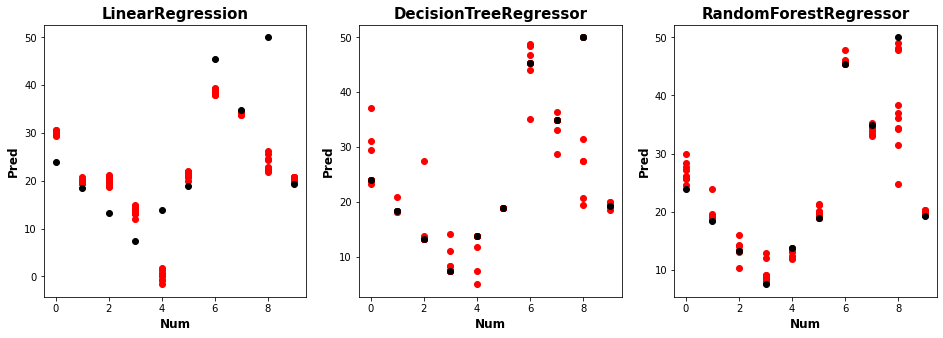

In [290]:
plot_predictions(models, X, y)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ 
1. *LinearRegression*: High Bias, Low Variance
2. *DecisionTree*: Middle Bias, High Variance
3. *RandomForest*: Low Bias, Middle Variance

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [18]:
from tqdm import tqdm

depth = np.arange(1, 11)
features = np.arange(1, X.shape[1] + 1)
depth_biases, depth_variances = [], []
features_biases, features_variances = [], []

for param in tqdm(depth):
    avg_bias, avg_var, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=param), X, y)
    depth_biases.append(avg_bias)
    depth_variances.append(avg_var)

for param in tqdm(features):
    avg_bias, avg_var, _ = compute_biase_variance(DecisionTreeRegressor(max_features=param), X, y)
    features_biases.append(avg_bias)
    features_variances.append(avg_var)


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


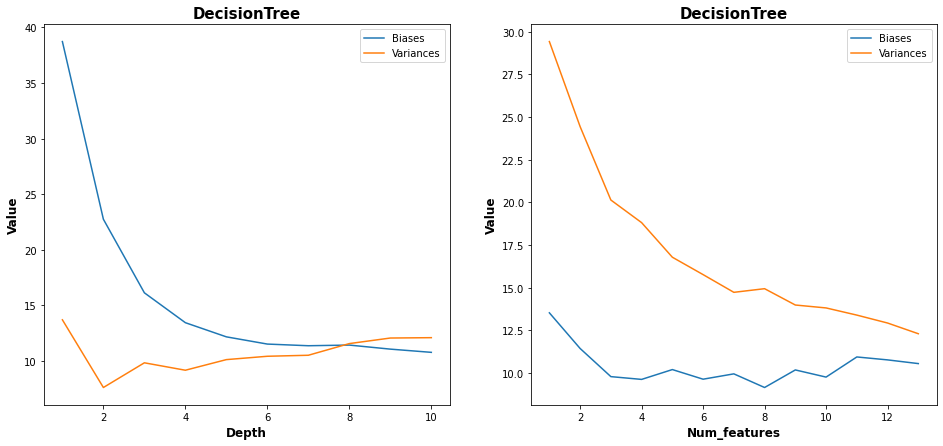

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].plot(depth, depth_biases, label='Biases')
axs[0].plot(depth, depth_variances, label='Variances')
axs[0].set_title('DecisionTree', weight='bold', size=15)
axs[0].set_xlabel('Depth', weight='bold', size=12)
axs[0].set_ylabel('Value', weight='bold', size=12)
axs[0].legend()


axs[1].plot(features, features_biases, label='Biases')
axs[1].plot(features, features_variances, label='Variances')
axs[1].set_title('DecisionTree', weight='bold', size=15)
axs[1].set_xlabel('Num_features', weight='bold', size=12)
axs[1].set_ylabel('Value', weight='bold', size=12)
axs[1].legend()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
estimators = 2 ** np.arange(1, 10)
biases_rf, variances_rf = [], []
biases_gb, variances_gb = [], []


for param in tqdm(estimators):
    ## random forest
    avg_bias, avg_var, _ = compute_biase_variance(RandomForestRegressor(n_estimators=param), X, y)    
    biases_rf.append(avg_bias)
    variances_rf.append(avg_var)

    ## gb
    avg_bias, avg_var, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=param), X, y)
    biases_gb.append(avg_bias)
    variances_gb.append(avg_var)


100%|██████████| 9/9 [07:26<00:00, 49.61s/it] 


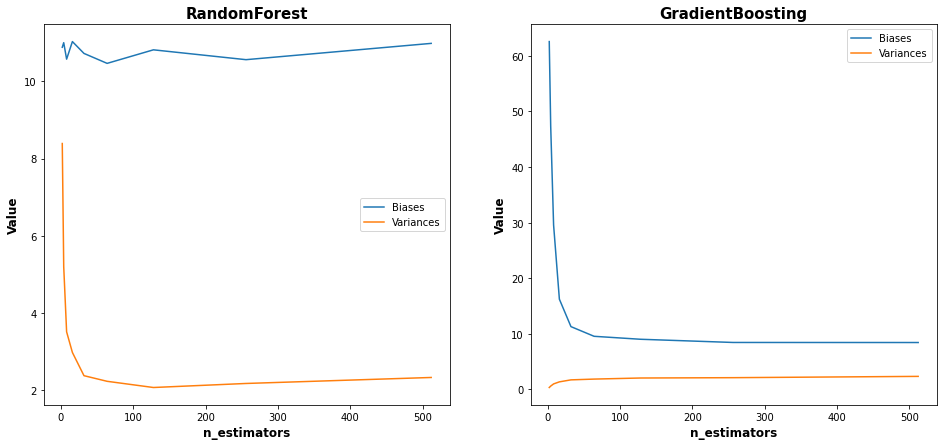

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
axs[0].plot(estimators, biases_rf, label='Biases')
axs[0].plot(estimators, variances_rf, label='Variances')
axs[0].set_title('RandomForest', weight='bold', size=15)
axs[0].set_xlabel('n_estimators', weight='bold', size=12)
axs[0].set_ylabel('Value', weight='bold', size=12)
axs[0].legend()


axs[1].plot(estimators, biases_gb, label='Biases')
axs[1].plot(estimators, variances_gb, label='Variances')
axs[1].set_title('GradientBoosting', weight='bold', size=15)
axs[1].set_xlabel('n_estimators', weight='bold', size=12)
axs[1].set_ylabel('Value', weight='bold', size=12)
axs[1].legend()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 
1. При увеличении глубины дерева, уменьшается его смещение, то есть модель дает более точные предсказания 
2. При увеличении количества рассматриваемых фичей при разбиении, уменьшается разброс алгоритма, что справедливо, так как модели становится "тяжело" выдавать разные предсказания.
3. При увеличении количества деревьев вполне закономерно уменьшается разброс алгоритма, здесь свое дело делает усреднение предсказаний по все большему количеству.
4. Изначально низкий разброс скорее всего обусловлен последовательностью обучения, по этой же причине и быстро уменьшается смещение, алгоритм быстро доходит то реального ответа.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

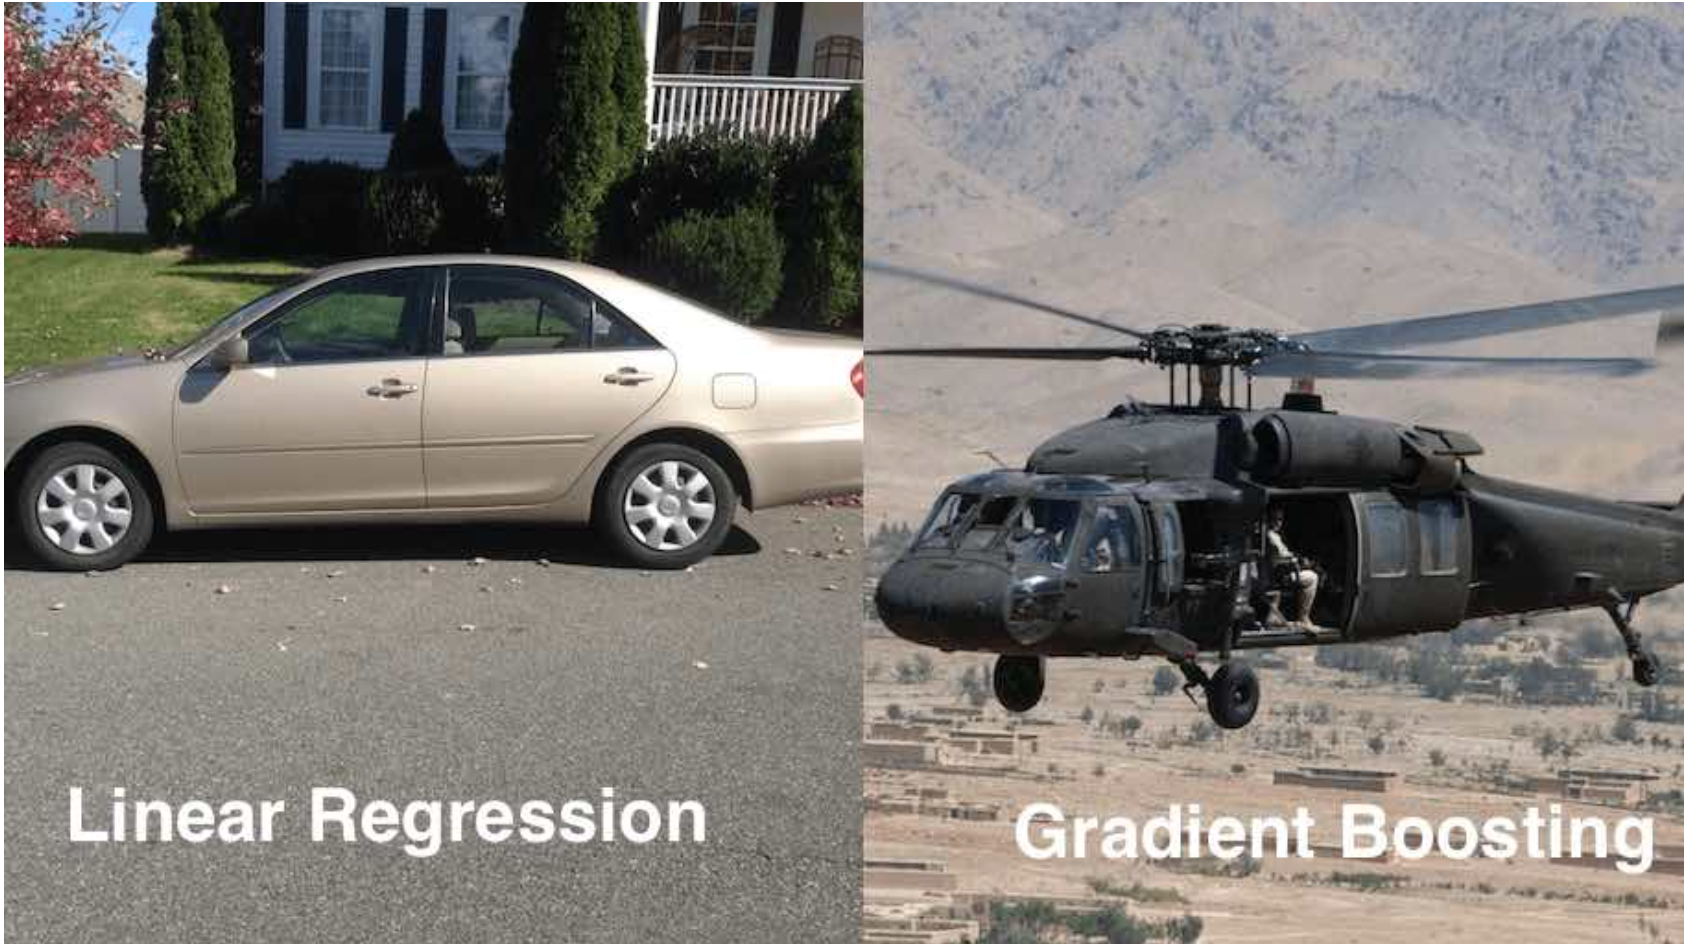

In [29]:
## притворяюсь вот этими типами которые мемы какие-то кидают в группу и типо смешно very HA-HA!
from PIL import Image
Image.open('lr_vs_gb.png')

# Вы видите ежа? А он есть! (с 3 дз) нужно нажать на еже enter

_______________1_11111____1_______________________
________1¶¶1¶¶¶¶¶_¶¶¶¶¶¶1¶¶¶¶¶¶¶__________________
______1¶¶¶¶¶¶¶¶¶¶¶1¶¶¶¶¶¶¶11¶¶¶¶¶¶¶1______________
____1¶¶¶¶¶1_1__1_1______________1¶¶¶11____________
____1¶¶¶1________________________¶¶¶¶¶____________
___¶¶¶1_________11¶________________1¶¶1___________
__¶¶¶¶______¶1¶_¶¶¶¶¶_______________¶¶¶¶__________
__¶¶¶¶_____¶¶¶¶¶¶1¶¶¶1________________¶¶¶1________
__¶1¶¶1__1¶¶¶¶¶1__1_¶¶_________________¶¶¶________
____¶¶¶¶¶¶11__¶_____1¶¶_________________1¶1_______
______¶¶¶¶1¶¶____¶¶¶__¶¶________________¶¶¶¶1_____
_______1¶111¶¶___1_¶¶__¶¶_________________¶1______
________¶______________¶¶_¶________________¶1_____
________¶_______________¶¶¶11_____________¶1¶¶____
________¶1_______________1¶¶¶___11¶1______1¶¶¶____
________¶1_________________¶¶¶1¶¶11¶¶¶¶_____¶¶1___
________¶11¶1___¶¶¶1________¶¶¶_______¶¶1___¶¶¶___
________1¶1_1¶_¶___¶¶________¶¶___¶¶1___¶1___¶¶¶__
____111__¶___¶11____¶________¶1__¶¶¶¶¶¶_1¶___¶¶¶__
__1¶¶¶¶¶1¶1___¶11¶1_¶1_¶¶___1¶¶¶___¶1_¶¶_¶1___¶¶¶_
__¶¶¶1¶¶¶1¶¶¶_¶_¶¶¶111¶¶1______1¶¶_¶_____¶1___1¶1_
__¶¶¶1¶¶¶¶1¶¶_1__¶¶1¶¶_1¶1_______¶¶______¶____¶¶¶_
__¶¶¶¶¶¶¶¶__1¶¶¶¶1_¶¶_____________¶¶____¶¶_____¶¶1
___1¶¶1___¶¶¶1111_¶¶_______________¶1¶¶¶¶______¶¶_
____11______11____¶¶_______________¶¶¶1________¶¶1
_____¶_____________¶______________1¶___________¶¶_
_____1¶___________________________¶1___________¶¶_
______¶¶1¶¶1__________¶1_________¶¶_____________¶1
_______1¶__¶1_____1¶¶__¶11____1¶¶¶_____________¶¶_
_______1111¶¶¶¶¶¶¶¶¶¶¶_¶¶¶¶¶¶¶¶¶__¶¶___________¶¶_
_______¶_1¶1__¶___1¶¶¶¶¶¶__¶_______1¶1_________1¶1
______¶1_¶¶¶_¶¶______11_¶__¶_________¶________1¶1_
______¶1_1¶__¶1________1¶_1¶_____1¶1_¶¶_______1¶¶_
______¶_¶¶1__¶_________¶1_¶¶_1¶¶1¶_¶11¶______1¶11_
______¶__¶___¶_________¶__¶¶_¶_1¶__¶¶¶¶______1¶1__
______¶¶_¶___¶________1¶__¶¶_¶__¶¶1__1¶_____1¶¶1__
_______¶¶¶___¶________¶1__1¶_¶___¶¶11¶¶____¶¶¶____
________1¶111¶________¶_11_¶¶¶______1¶1___1¶11____
_________1¶1¶¶¶1_¶___1¶11¶1¶11¶1______¶_1¶1¶1_____
_________1¶1_11¶¶¶¶¶¶¶¶11¶¶¶___¶¶¶¶¶¶¶1¶¶¶1_______
__________1¶¶¶________1¶1¶¶______11_¶¶¶¶__________
____________1¶¶________1¶1_________¶¶11¶__________
______________¶¶¶________________¶¶¶______________
________________1¶¶11_________¶¶¶¶________________
_________________1¶¶¶¶¶1______¶¶__________________
_______________1¶11¶11¶¶¶¶¶¶¶¶¶¶__________________
________________¶1_¶11¶¶1__¶¶1____________________